In [1]:
import pandas as pd
import numpy as np
import random

# File operations
from copy import deepcopy
import glob
import os
from pathlib import Path

# Stats
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr, wilcoxon, mannwhitneyu, zscore
import statsmodels.stats.multitest

# Neuromaps
import neuromaps
from neuromaps.parcellate import Parcellater
from neuromaps import datasets, images, nulls, resampling, stats
from nibabel import freesurfer as fs
import nibabel as nib
from neuromaps.datasets import fetch_annotation, fetch_fslr
from enigmatoolbox.datasets import load_sc, load_fc, load_fc_as_one

# Set seed to 127
random.seed(127)

# Add connectome workbench to path
os.environ['PATH'] = os.environ['PATH'] + ':/Applications/workbench/bin_macosx64'

%load_ext rpy2.ipython

In [2]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(circlize)
    library(ComplexHeatmap)
    library(cowplot)
    library(dendextend)
    library(FactoMineR)
    library(GGally)
    library(ggseg)
    library(glue)
    library(grid)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

# Load in the data and filter to Pearson correlation

In [3]:
#### GROUP-AVERAGED FUNCTIONAL CONNECTOME FROM ENIGMA #### 
# Load cortico-cortical functional connectivity data
fc_ctx, fc_ctx_labels, _, _ = load_fc(parcellation='aparc')

# Read in preprocessed Pearson-based functional connectivity data from ENIGMA
HCP_ctx_avg_Pearson_FC = (pd.DataFrame(fc_ctx, columns=fc_ctx_labels)
                      .assign(Brain_Region_From = fc_ctx_labels)
                      .melt(id_vars=["Brain_Region_From"], 
                             var_name="Brain_Region_To", 
                             value_name="Mean_Pearson_R")
                      .assign(Base_Region_From = lambda x: x['Brain_Region_From'].str.replace("L_", "").str.replace("R_", ""),
                              Base_Region_To = lambda x: x['Brain_Region_To'].str.replace("L_", "").str.replace("R_", ""),
                              Hemi_From = lambda x: np.where(x['Brain_Region_From'].str.startswith("L_"), "Left", "Right"),
                              Hemi_To = lambda x: np.where(x['Brain_Region_To'].str.startswith("L_"), "Left", "Right"))
)

pearson_homotopic_res_mean = (HCP_ctx_avg_Pearson_FC
                              .query("Base_Region_From == Base_Region_To")
                              .groupby(["Base_Region_From"])['Mean_Pearson_R']
                              .mean() 
                              .reset_index()
                              .rename(columns={"Base_Region_From": "Base_Region"})
                              )

pearson_homotopic_res_for_dk = (HCP_ctx_avg_Pearson_FC
                                .query("Base_Region_From == Base_Region_To")
                                  .groupby(["Base_Region_To", 'Hemi_From'])['Mean_Pearson_R']
                                  .mean()
                                  .reset_index()
                                    )

## Visualize the mean Pearson FC from L--R and R--L in the brain (averaged across hemispheres, first)

Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'


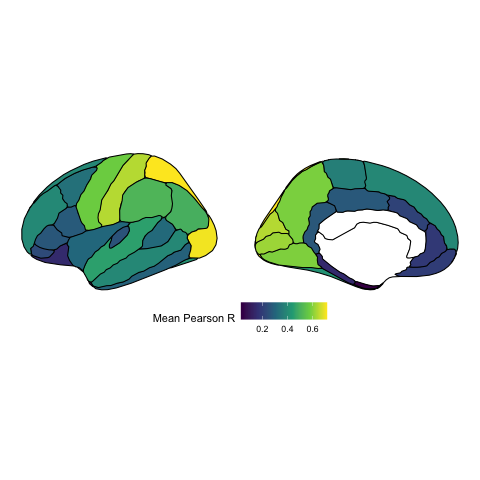

In [4]:
%%R -i pearson_homotopic_res_mean

### Pearson FC in brain ###
pearson_homotopic_res_mean %>%
  ungroup() %>%
  mutate(label = glue("lh_{Base_Region}")) %>%
  left_join(., as_tibble(dk)) %>%
  ggseg(atlas = dk, mapping = aes(fill = Mean_Pearson_R),
        position = "stacked", colour = "black", hemisphere="left",
        linewidth=0.5) +
  theme_void() +
  labs(fill = "Mean Pearson R") +
  theme(plot.title = element_blank(),
        legend.position = "bottom") +
  scale_fill_viridis_c(na.value = "white")
# ggsave("../plots/brain_maps_corrs/Mean_LR_averaged_Pearson_R_ggseg.svg", width = 4, height = 3)

## Compare region-wise hierarchy values with Pearson-based homotopic connectivity (HoFC)

In [5]:
# Read in brain region lookup table
brain_region_info = pd.read_csv("../data/Brain_Region_Info.csv")

# Define the left- and right-hemisphere Desikan-Killiany (DK) atlas
lh_dk = "../data/fsaverage/lh.aparc.annot"
rh_dk = "../data/fsaverage/rh.aparc.annot"

if not os.path.exists("../data/hierarchy_dk_neuromaps_res.csv"):
    nm_atlas_df = pd.read_csv('hierarchy_neuromaps_atlases.csv')

    # Convert the DK atlas to gifti format
    dk_gifti = neuromaps.images.annot_to_gifti((lh_dk, rh_dk), background=None)
    dk_gifti = neuromaps.images.relabel_gifti(dk_gifti)

    # Fit a Parcellator object
    parc = Parcellater(dk_gifti, 'fsaverage', resampling_target='parcellation')

    # Loop through each atlas, extract the values in Desikan-Killiany space, and create a dataframe
    all_dk_neuromaps_res_list = []
    for i, row in nm_atlas_df.iterrows():
        this_row_category = row['Category']
        this_row_desc = row['Description']
        source, desc, space, den = row['Filename'].split('-')

        try:
            print(f"Fetching {source} {desc} {space} {den}")
            this_atlas_data = fetch_annotation(source=source, desc=desc, space=space, 
                                                den=den, data_dir=Path("/Users/abry4213/neuromaps-data"))
            
            # Extract this atlas' values in Desikan-Killiany space
            parc_iter = deepcopy(parc)
            this_atlas_data_in_dk = parc_iter.fit_transform(this_atlas_data, space)

            # Create a dataframe
            this_atlas_data_in_dk_df = pd.DataFrame({'Category': this_row_category,
                                                        'Description': this_row_desc,
                                                        'Region_Index': range(len(this_atlas_data_in_dk)),
                                                        'Value': this_atlas_data_in_dk}).merge(brain_region_info, on="Region_Index")
            
            # Append to the list
            all_dk_neuromaps_res_list.append(this_atlas_data_in_dk_df)
        
        except Exception as e:
            print(f"Error parcellating {source} {desc} {space} {den}: {e}")
            continue

    # Concatenate all the dataframes
    hierarchy_dk_neuromaps_res = pd.concat(all_dk_neuromaps_res_list)

    # Save the results
    hierarchy_dk_neuromaps_res.to_csv("../data/hierarchy_dk_neuromaps_res.csv", index=False)

else:
    hierarchy_dk_neuromaps_res = pd.read_csv("../data/hierarchy_dk_neuromaps_res.csv")

hierarchy_dk_neuromaps_res_hemi_avg = hierarchy_dk_neuromaps_res.groupby(['Category', 'Description', 'Base_Region'])['Value'].mean().reset_index()

## How do structural, functional, and transcriptomic measures of the cortical hierarchy correlate with Pearson correlation-based functional connectivity?

In [6]:
# Group by 'Category' and 'Description' and compute the Spearman correlation
spearman_corrs_pearson = (hierarchy_dk_neuromaps_res_hemi_avg
                              .merge(pearson_homotopic_res_mean, on='Base_Region', how='left')
                              .groupby(['Category', 'Description'])
                              .apply(lambda x: spearmanr(x['Value'], x['Mean_Pearson_R'])).apply(pd.Series)
                              .reset_index()
                              .assign(SPI = 'Pearson_R'))

# Rename the columns for clarity
spearman_corrs_pearson.columns = ['Category', 'Description', 'Spearman_Correlation', 'p_value', 'SPI']

# Display the results
spearman_corrs_pearson['p_val_BH'] = statsmodels.stats.multitest.multipletests(spearman_corrs_pearson.p_value, method="fdr_bh")[1]

# Filter to significant results
spearman_corrs_pearson_sig = spearman_corrs_pearson.query("p_val_BH < 0.05 & abs(Spearman_Correlation) > 0.5")

# Filter neuromaps data to the significant results
hierarchy_dk_neuromaps_res_hemi_avg_sig = hierarchy_dk_neuromaps_res_hemi_avg.merge(spearman_corrs_pearson_sig, on=['Category', 'Description'], how='inner')
hierarchy_neuromaps_vs_pearson_hemi_avg_sig = hierarchy_dk_neuromaps_res_hemi_avg_sig.merge(pearson_homotopic_res_mean, on='Base_Region', how='left')

/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_44542/293204334.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spearman_corrs_pearson = (hierarchy_dk_neuromaps_res_hemi_avg


Joining with `by = join_by(label)`
Joining with `by = join_by(label)`
Joining with `by = join_by(label)`
Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'


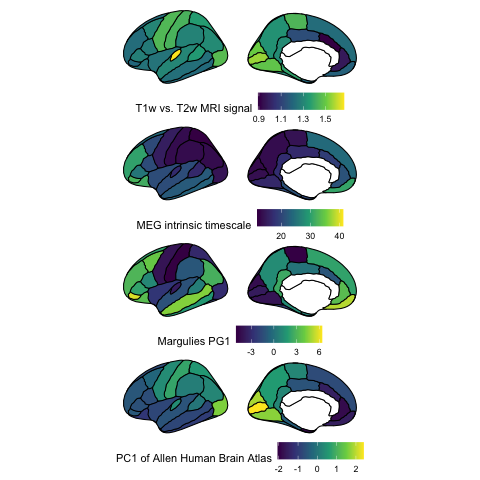

In [7]:
%%R -i hierarchy_dk_neuromaps_res_hemi_avg_sig

all_ggseg_plots_list <- list()

for (desc in unique(hierarchy_dk_neuromaps_res_hemi_avg_sig$Description)) {
      desc_p <- hierarchy_dk_neuromaps_res_hemi_avg_sig %>%
            filter(Description==desc) %>% 
            mutate(label = glue("lh_{Base_Region}")) %>%
            left_join(., as_tibble(dk)) %>%
            ggseg(atlas = dk, mapping = aes(fill = Value),
                  position = "stacked", colour = "black", hemisphere="left",
                  linewidth=0.5) +
            theme_void() +
            labs(fill = desc) +
            theme(plot.title = element_blank(),
                  legend.position = "bottom") +
            scale_fill_viridis_c(na.value = "white")

      all_ggseg_plots_list[[desc]] <- desc_p
}

wrap_plots(all_ggseg_plots_list, ncol=1)
# ggsave("../plots/brain_maps_corrs/Pearson_vs_hierarchy_ggseg_res.svg", width=4, height=6, dpi=300, units="in")


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: The dot-dot notation (`..r.label..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(r.label)` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 

R[write to console]: 2: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 

R[write to console]: 3: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 

R[write to console]: 4: The following aesthetics were dropped 

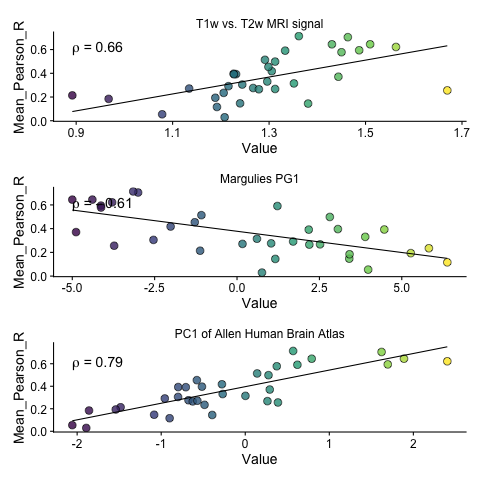

In [8]:
%%R -i hierarchy_neuromaps_vs_pearson_hemi_avg_sig

all_scatter_plots_list <- list()

for (desc in unique(hierarchy_neuromaps_vs_pearson_hemi_avg_sig$Description)) {
    if (desc != "MEG intrinsic timescale") {
        desc_p <- hierarchy_neuromaps_vs_pearson_hemi_avg_sig %>%
                    filter(Description==desc) %>% 
                    ggplot(data=., mapping=aes(x=Value, y=Mean_Pearson_R, fill=Value)) +
                    geom_point(shape=21, color='black', size=3.25, alpha=0.8) +
                    # Facet wrap but repeat axis titles for each facet
                    facet_wrap(Description ~ ., scales="free", ncol=1, axis.labels = 'all') +
                    ggpubr::stat_cor(method="spearman", cor.coef.name="rho", size=5, aes(label = ..r.label..)) +
                    geom_smooth(method='lm', color='black', se=FALSE, linewidth=0.5) +
                    theme(legend.position='none') +
                    scale_fill_viridis_c() +
                    theme(strip.background = element_blank())

            all_scatter_plots_list[[desc]] <- desc_p
    }
}
      
wrap_plots(all_scatter_plots_list, ncol=1)
# ggsave("../plots/brain_maps_corrs/Hierarchy_maps_with_pearson_correlations_scatters.svg", width=2.75, height=8, dpi=300, units="in")

## Spin test to evaluate statistical significance

In [9]:
%%R -i hierarchy_dk_neuromaps_res_hemi_avg -o hierarchy_dk_neuromaps_res_hemi_avg

hierarchy_dk_neuromaps_res_hemi_avg <- hierarchy_dk_neuromaps_res_hemi_avg %>% 
    filter(Description != "MEG intrinsic timescale") %>%
    mutate(Desc = case_when(Description=="T1w vs. T2w MRI signal" ~ "T1wT2w",
                            Description=="Margulies PG1" ~ "Margulies_PG1",
                            Description=="PC1 of Allen Human Brain Atlas" ~ "AHBA_PC1"))

In [10]:
# Convert the DK atlas to gifti format
# dk_gifti = neuromaps.images.annot_to_gifti((lh_dk, rh_dk), background=None)
dk_gifti = neuromaps.images.annot_to_gifti(lh_dk, background=None)
dk_gifti = neuromaps.images.relabel_gifti(dk_gifti)

# Fit a Parcellator object
dk_parc = Parcellater(dk_gifti, 'fsLR', resampling_target='parcellation', hemi='L')

# Create a big dataframe
HoFC_vs_hierarchy_df_hemi_avg = (hierarchy_dk_neuromaps_res_hemi_avg
                                 .pivot(index=['Base_Region'], columns=['Desc'], values='Value')
                                 .merge(pearson_homotopic_res_mean, on='Base_Region', how='left')
)

# Create a dictionary of values to compare
hierarchy_measures_dict = {'AHBA_PC1': HoFC_vs_hierarchy_df_hemi_avg['AHBA_PC1'].values,
                           'Margulies_PG1': HoFC_vs_hierarchy_df_hemi_avg['Margulies_PG1'].values,
                           'T1wT2w': HoFC_vs_hierarchy_df_hemi_avg['T1wT2w'].values}

rng = np.random.default_rng(seed=127)  # for reproducibility
HoFC_measure = HoFC_vs_hierarchy_df_hemi_avg['Mean_Pearson_R'].values

# Assume you are working with fsaverage and the Desikan-Killiany atlas
atlas = 'fsLR'

for key, value in hierarchy_measures_dict.items():
    comparison_values = hierarchy_measures_dict[key]


    # Use DEF to generate the nulls
    spins = nulls.alexander_bloch(comparison_values, atlas=atlas, parcellation=dk_gifti, density='164k',
                                n_perm=10000, seed=127)

    # Step 4: Compare ABC and DEF using the nulls
    stat, p = stats.compare_images(HoFC_measure, comparison_values, nulls=spins, metric='spearmanr')

    print(f"Comparison: {key}")
    print(f"Observed correlation: {stat:.3f}")
    print(f"P-value (spin test): {p:.4f}")

Comparison: AHBA_PC1
Observed correlation: 0.794
P-value (spin test): 0.0002
Comparison: Margulies_PG1
Observed correlation: -0.606
P-value (spin test): 0.0011
Comparison: T1wT2w
Observed correlation: 0.661
P-value (spin test): 0.0005
